**Approach-<br>- Regular expression cleaning, tokenization, spacy lemmatization<br>- Download pre-trained glove embeddings<br>- Feed to Embedding LSTM network**

In [1]:
import regex as re
import string
import random
import os
import tqdm
import numpy as np
import pandas as pd

import requests
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing import sequence
import tensorflow.keras.backend as K

import spacy

In [2]:
#download nltk stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#set display option
pd.options.display.max_colwidth = 100
tf.random.set_seed(42)

**Data Reading and Understanding**

In [4]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [5]:
print (train_df.info())
print ("# of training records: ", len(train_df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
# of training records:  7613


In [6]:
#to see distribution of target labels
train_df['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [7]:
#read test data
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


**Look at few of the tweets**

In [8]:
train_df.head()[['text','target']]

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


**Checking- if features keyword and location are useful and should be retained**

In [9]:
train_df[~train_df['keyword'].isnull()][['keyword', 'text']]

,keyword,text
31,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
32,ablaze,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi
34,ablaze,Crying out for more! Set me ablaze
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N
...,...,...
7578,wrecked,@jt_ruff23 @cameronhacker and I wrecked you both
7579,wrecked,Three days off from work and they've pretty much all been wrecked hahaha shoutout to my family f...
7580,wrecked,#FX #forex #trading Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/7enNulLKzM
7581,wrecked,@engineshed Great atmosphere at the British Lion gig tonight. Hearing is wrecked. http://t.co/oM...


In [10]:
len(train_df['location'].unique())

3342

**Dropping the features: keyword and location**

In [11]:
train_df.drop(columns=['keyword', 'location'], inplace=True)

**Data Cleaning and Preprocessing**

In [12]:
#Tweet tokenizer to take care of emojis in tweets
tokenizer = TweetTokenizer()
spacy_en = spacy.load('en_core_web_sm', disable=['parser','ner'])

In [13]:
def clean_text(text):  
  cleaned_text = text.lower()
  
  #remove chars like hashtags, web addresses
  cleaned_text = re.sub(r'#|@\S+|<.*?>|http\S+|[0-9,.]+\S+', '', cleaned_text)

  cleaned_text = tokenizer.tokenize(cleaned_text)
  cleaned_text = ' '.join([word for word in cleaned_text if word not in string.punctuation and word not in stopwords.words('english')])
    
  doc = spacy_en(cleaned_text)
  cleaned_text = ' '.join([token.lemma_ for token in doc if token.lemma_ not in ['-PRON-'] and token.pos_ not in ['DET','-PRON']])
  return cleaned_text

In [14]:
train_df['cleaned_text'] = train_df.apply(lambda row : clean_text(row['text']), axis=1)

In [15]:
#Tokenizer to train word vocabulary and generate sequences of optimal length to be fed to embeddings layer
class CustomTokenizer:
  def __init__(self):
    self.tokenizer = Tokenizer(num_words=20000)

  def fit(self, train_text):
    max_length = max(train_text.map(len))
    self.max_length = min(max_length, 50)
    self.tokenizer.fit_on_texts(train_text)

  def vectorize_input(self,tweets):
    tweets_seq = self.tokenizer.texts_to_sequences(tweets)
    tweets_seq = sequence.pad_sequences(tweets_seq, maxlen=self.max_length, padding='post', truncating='post')
    return tweets_seq

In [16]:
cust_tokenize = CustomTokenizer()

**Modelling**

In [17]:
#Download the glove embeddings
URL = "http://nlp.stanford.edu/data/glove.42B.300d.zip"
target_zip = 'glove.zip'
target_file = 'glove.42B.300d.txt'
GLOVE_DIM = 300

In [18]:
def fetch_glove_embeddings(url, target_zip):
  if os.path.exists(target_file):
    print("Glove embeddings already exist!!")
    return

  response = requests.get(URL, stream=True)
  with open(target_zip, 'wb') as file_handle:
    for chunk in tqdm.tqdm(response.iter_content(chunk_size=512)):
      if chunk:      
        file_handle.write(chunk)

  zf = zipfile.ZipFile(target_zip)
  zf.extractall()

In [19]:
fetch_glove_embeddings(URL, target_zip)

3667580it [14:55, 4094.60it/s]


In [20]:
#Load the gensim pre-trained embeddings and convert them to word2vec format
word2vec_output_file = 'glove.42B.300d.w2v.txt'
glove2word2vec(target_file, word2vec_output_file)
glove_model = KeyedVectors.load_word2vec_format('glove.42B.300d.w2v.txt', binary=False)

In [21]:
#word embeddings for entire vocabulary from tokenizer
def generate_word_embeddings(word_vocab):
  num_words = len(word_vocab) + 1
  word_embeddings = np.zeros((num_words, GLOVE_DIM))

  for word, i in word_vocab.items():
    if word in glove_model:
      word_embeddings[i] = glove_model[word]

  return word_embeddings

**Helper callbacks**

In [22]:
#Callback to compute f1 score on receiving precision and recall after every epoch
class F1_score_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    lr = self.model.optimizer.lr
    train_precision = logs['precision']
    train_recall = logs['recall']
    train_f1_score = 2 * train_precision * train_recall / (train_precision + train_recall + tf.keras.backend.epsilon())

    val_precision = logs['val_precision']
    val_recall = logs['val_recall']
    val_f1_score = 2 * val_precision * val_recall / (val_precision + val_recall + tf.keras.backend.epsilon())

    print ("Learning rate: {} Train f1score: {} Val f1score: {}".format(lr, train_f1_score, val_f1_score))

In [23]:
#Custom metric f1-score to be used for monitoring
def recall(y_true, y_pred):    
    true_positives = K.sum(K.round(y_true * y_pred))
    possible_positives = K.sum(y_true)
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(y_true * y_pred))
    predicted_positives = K.sum(K.round(y_pred))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

**Train - 80% Val - 20% of entire training data available**

In [24]:
X = train_df['cleaned_text']
y = train_df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=100)

cust_tokenize.fit(X_train)
word_embeddings = generate_word_embeddings(cust_tokenize.tokenizer.word_index)

X_train_transformed = cust_tokenize.vectorize_input(X_train)
X_val_transformed = cust_tokenize.vectorize_input(X_val)

In [25]:
INPUT_DIM = cust_tokenize.max_length
BATCH_SZ = 32

In [26]:
#Define a sequential model with embedding layer to generate embeddings of input sequences
model = tf.keras.models.Sequential([
          tf.keras.layers.Embedding(word_embeddings.shape[0], GLOVE_DIM, embeddings_initializer=tf.constant_initializer(word_embeddings),
                                    input_length = INPUT_DIM, trainable=False),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.LSTM(128),          
          tf.keras.layers.Dense(1, activation='sigmoid')
          ])

optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer, loss=tf.keras.losses.BinaryCrossentropy(), 
               metrics=['acc', f1_score])
  
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch / 30))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, verbose=1,
                                                     mode='max', monitor='val_f1_score')
  
history = model.fit(X_train_transformed, y_train, batch_size=32, epochs=100, validation_data=(X_val_transformed, y_val), callbacks=[lr_schedule, early_stopping, model_checkpoint])

Epoch 1/100
191/191 [==============================] - 17s 77ms/step - loss: 0.5777 - acc: 0.7154 - f1_score: 0.5395 - val_loss: 0.4731 - val_acc: 0.8050 - val_f1_score: 0.7294

Epoch 00001: val_f1_score improved from -inf to 0.72940, saving model to best_model.h5
Epoch 2/100
191/191 [==============================] - 14s 73ms/step - loss: 0.4720 - acc: 0.8062 - f1_score: 0.7433 - val_loss: 0.4563 - val_acc: 0.8089 - val_f1_score: 0.7536

Epoch 00002: val_f1_score improved from 0.72940 to 0.75356, saving model to best_model.h5
Epoch 3/100
191/191 [==============================] - 14s 74ms/step - loss: 0.4594 - acc: 0.8034 - f1_score: 0.7400 - val_loss: 0.4968 - val_acc: 0.7965 - val_f1_score: 0.7102

Epoch 00003: val_f1_score did not improve from 0.75356
Epoch 4/100
191/191 [==============================] - 14s 75ms/step - loss: 0.4532 - acc: 0.8087 - f1_score: 0.7429 - val_loss: 0.4338 - val_acc: 0.8116 - val_f1_score: 0.7432

Epoch 00004: val_f1_score did not improve from 0.75356
E

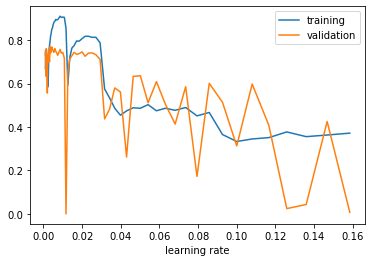

In [27]:
#plot precision and recall with respect to learning rate
plt.xlabel("learning rate")
plt.plot(history.history['lr'], history.history['f1_score'], label='training')
plt.plot(history.history['lr'], history.history['val_f1_score'], label='validation')
plt.legend(loc='upper right')
plt.show()

In [28]:
#Loading the best model to be used for predictions
reloaded_model = tf.keras.models.load_model('./best_model.h5', custom_objects={'f1_score':f1_score})
reloaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           3232200   
_________________________________________________________________
dropout (Dropout)            (None, 50, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,451,977
Trainable params: 219,777
Non-trainable params: 3,232,200
_________________________________________________________________


**Prediction on test set to be evaluated**

In [29]:
test_df.drop(columns=['keyword', 'location'], inplace=True)
test_df['cleaned_text'] = test_df.apply(lambda row:clean_text(row['text']), axis=1)
test_df['cleaned_text'][0:5]

0                                      happen terrible car crash
1              hear earthquake different city stay safe everyone
2    forest fire spot pond geese flee across street can not save
3                           apocalypse lighting spokane wildfire
4                             typhoon soudelor kill china taiwan
Name: cleaned_text, dtype: object

In [30]:
test_transformed = cust_tokenize.vectorize_input(test_df['cleaned_text'])
test_predictions = reloaded_model.predict(test_transformed)
test_predictions = np.round(test_predictions).astype(int)
test_predictions = test_predictions.reshape((3263,))

In [31]:
submission = pd.DataFrame({'id':test_df['id'], 'target':test_predictions})
submission.to_csv('./submission.csv', index=False)